# Lab9 - Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt

## Working with Shape File

### Loading Census Tract Shape File¶

In [3]:
from geopandas import GeoDataFrame
shape_path="Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010
ct_shape.tail()

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry
BoroCT2010,,,,,,,,,,,,
1029700,1029700,1,Manhattan,I,029700,297,MN99,park-cemetery-etc-Manhattan,3801,9.961849e+06,20553.099113,(POLYGON ((-73.92640556921116 40.8776214765373...
3000100,3000100,3,Brooklyn,I,000100,1,BK09,Brooklyn Heights-Cobble Hill,4004,2.237282e+06,6527.281839,"POLYGON ((-73.9909320180753 40.70076621604873,..."
3000301,3000301,3,Brooklyn,I,000301,3.01,BK09,Brooklyn Heights-Cobble Hill,4004,2.142139e+06,6466.952122,POLYGON ((-73.99429211012634 40.69853508000104...
1023300,1023300,1,Manhattan,E,023300,233,MN04,Hamilton Heights,3802,2.535724e+06,7136.778935,"POLYGON ((-73.9452963315124 40.82839997666752,..."
1023700,1023700,1,Manhattan,E,023700,237,MN04,Hamilton Heights,3802,2.897558e+06,7073.400099,POLYGON ((-73.94297966199173 40.83156798036202...


### Coordinate systems, projections, and transformations 

In [4]:
# importing package for manipulating shapefiles in Python and coordinate system
from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Census Tract boundaries colored by boroughs

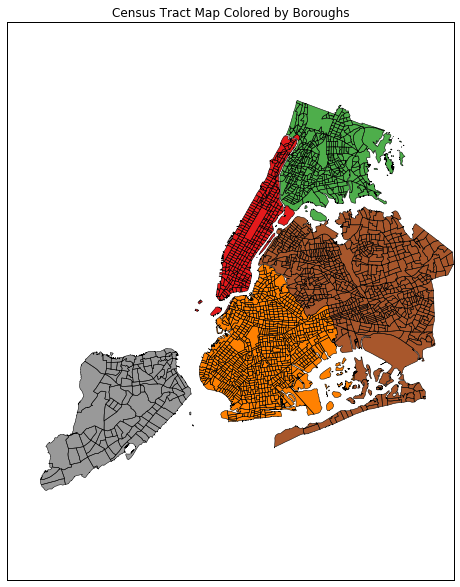

In [5]:
f, ax = plt.subplots(figsize=(8,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract Map Colored by Boroughs")

Fig 1: New York City boroughs shown in different colors, with census tracts delineated.

### Map NYC Population density

#### Load Census Data for 2010

In [6]:
ct_data=DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add population density to CT shapefile

In [7]:
# hm so it automatically knows which column to join them on?

ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Visualize the Population density for 2010

/opt/rh/anaconda/root/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


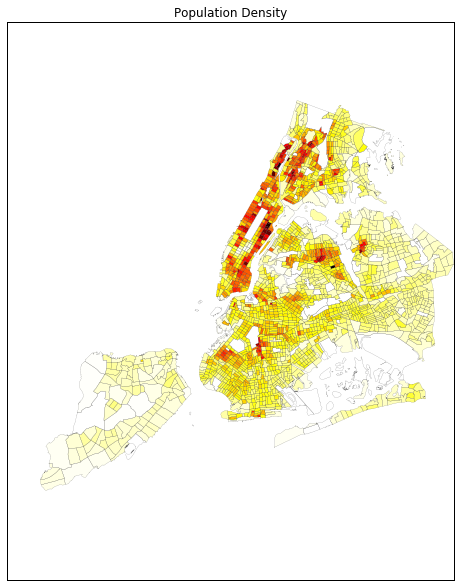

In [8]:
f, ax = plt.subplots(figsize=(8,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density")

Fig 2: Population density is shown in each census tract in New York City, with the greatest concentration of the most dense tracts clearly in Manhattan and the Bronx.

## Explore CitiBike data

### Load CitiBike data

In [9]:
df_bike_monthly=DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0
2013-12-31,1299,1650,4081,1686,3046,1575,830,1890,2048,1009,...,0,0,0,0,0,0,0,0,0,0
2014-01-31,956,1337,3178,1251,1920,1130,477,1412,1082,681,...,0,0,0,0,0,0,0,0,0,0
2014-02-28,650,960,2920,676,1808,933,508,1045,963,530,...,0,0,0,0,0,0,0,0,0,0
2014-03-31,804,1559,5102,1441,2643,1477,849,2004,2105,880,...,0,0,0,0,0,0,0,0,0,0


## using Avikal's method to split the data into winter set

In [10]:
#extracting winter (June-September) months
winter = df_bike_monthly.iloc[:3]
for i in range (1,4):
    winter = winter.append(df_bike_monthly.iloc[(12 * i) - 1:(12 * i) + 3])
    
winter.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2014-06-30,2048,3306,9626,3515,7255,2942,1917,3702,3694,2422,...,0,0,0,0,0,0,0,0,0,0
2014-07-31,2252,3216,9825,3509,7014,3224,2195,3732,4042,2268,...,0,0,0,0,0,0,0,0,0,0


In [11]:
#extracting winter (December-March) months
winter = df_bike_monthly.iloc[5:9]
for i in range (1,4):
    winter = winter.append(df_bike_monthly.iloc[(12 * i) - 7:(12 * i) - 3])
    
winter.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-12-31,1299,1650,4081,1686,3046,1575,830,1890,2048,1009,...,0,0,0,0,0,0,0,0,0,0
2014-01-31,956,1337,3178,1251,1920,1130,477,1412,1082,681,...,0,0,0,0,0,0,0,0,0,0
2014-02-28,650,960,2920,676,1808,933,508,1045,963,530,...,0,0,0,0,0,0,0,0,0,0
2014-03-31,804,1559,5102,1441,2643,1477,849,2004,2105,880,...,0,0,0,0,0,0,0,0,0,0
2013-12-31,1299,1650,4081,1686,3046,1575,830,1890,2048,1009,...,0,0,0,0,0,0,0,0,0,0


### Time Series Analysis for year-round data

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


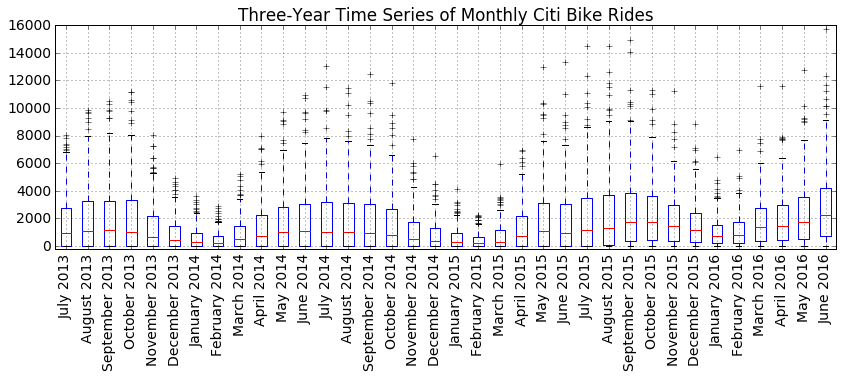

In [12]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_=df_bike_monthly.copy()
df_bike_monthly_.index=df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])
plt.title("Three-Year Time Series of Monthly Citi Bike Rides")

Fig 3: Time series analysis for three years of data shows a clear seasonal trend with higher ridership in the winter months.

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [13]:
station_id=DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Coordinates (Lat & Lon)

In [14]:
import shapely
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [15]:
a=[]
# check for each citibike stations to see what CT they belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [16]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

In [17]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100


## Add Monthly rides to the station GeoDataFrame with CT code

In [18]:
# Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['MonthlyAve']=df_bike_monthly.sum()

In [19]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,69308
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,102824
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,273525
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,101949
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,184044


### Add winter Monthly Ridership to the GeoDataFrame

In [20]:
station_id['winterMonthlyAve']= winter.mean()
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAve,winterMonthlyAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,69308,1054.5000
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,102824,1351.1875
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,273525,4263.8125
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,101949,1537.1875
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,184044,2546.0000


### Add winter Monthly Ridership to CT shapefile

In [21]:
temp=station_id[['winterMonthlyAve']]
temp['station_id']=station_id.index
temp.index=station_id['BoroCT2010']
ct_shape_winterMonthlyAve=ct_shape.join(temp)
ct_shape_winterMonthlyAve.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


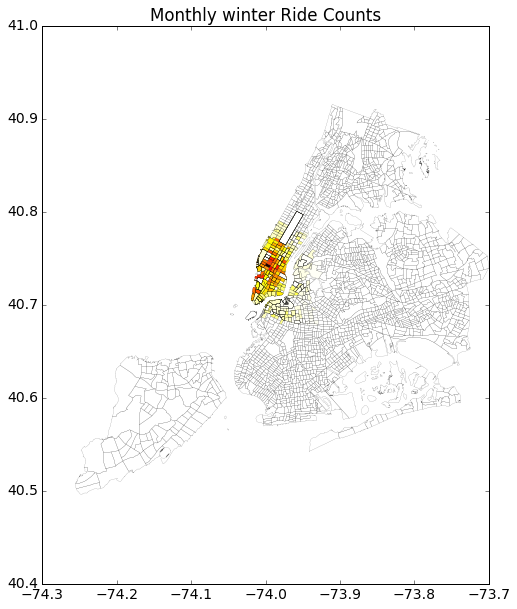

In [22]:
f, ax = plt.subplots(figsize=(8,10))
ct_shape_winterMonthlyAve.plot(column='winterMonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly winter Ride Counts")

Fig 6: wintertime rides are heavily concentrated in mid Manhattan.

### Removing the CTs that are out of zoom boundaries

In [23]:
ct_shape_winterMonthlyAve_Zoom=(ct_shape_winterMonthlyAve[ct_shape_winterMonthlyAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [24]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp.winterMonthlyAve)

Total number of CTs: 2166
Number of zoomed CTs: 543


### Map the zoomed winter monthly rides 

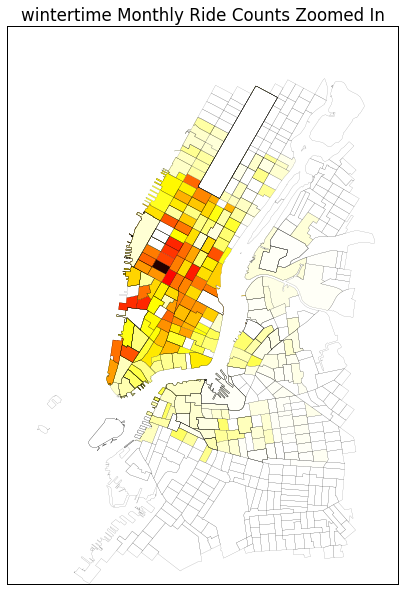

In [25]:
f, ax = plt.subplots(figsize=(7,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_winterMonthlyAve_Zoom.plot(column='winterMonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("wintertime Monthly Ride Counts Zoomed In")

Fig 7: The zoomed-in map again shows that wintertime rides are heavily concentrated in mid Manhattan, with less ridership in lower Manhattan compared with summertime, even adjusted for overall seasonal variation.

### Export Shapefile CTs in the CitiBike Zone

In [26]:
path='Output/ct_shape_winterMonthlyAve_Zoom.shp'
ct_shape_winterMonthlyAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis

In [27]:
import pysal as ps

### Spatial Weights
Contiguity: Queen Weights

In [28]:
qW_CT_winter=ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [29]:
qW_CT_winter[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [30]:
qW_CT_winter.cardinalities[10]

9

#### Matrix of Weights

In [31]:
Wmatrix, ids = qW_CT_winter.full()

In [32]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [33]:
qW_CT_winter.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  (when neighboring observations affect one another)
Similarity of CT neighbors can be measured by means of spatial lag as follows:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [34]:
winterMonthlyRide=ct_shape_winterMonthlyAve_Zoom.winterMonthlyAve
winterMonthlyRideLag=ps.lag_spatial(qW_CT_winter, winterMonthlyRide)

#### Create Quantiles for mapping

In [35]:
# "when you don't know the nature of your data, the best way is quantile"

winterMonthlyRideLagQ10 = ps.Quantiles(winterMonthlyRideLag, k=10)
winterMonthlyRideLagQ10

                  Quantiles                  
 
 Lower              Upper               Count
           x[i] <=    0.000               159
   0.000 < x[i] <=    3.446                 2
   3.446 < x[i] <=   61.379                78
  61.379 < x[i] <=  155.196                80
 155.196 < x[i] <=  255.046                79
 255.046 < x[i] <=  367.326                80
 367.326 < x[i] <=  898.656                79
 898.656 < x[i] <= 1205.866                80
1205.866 < x[i] <= 1467.853                79
1467.853 < x[i] <= 2376.509                80

#### Map the wintertime monthly rides lag

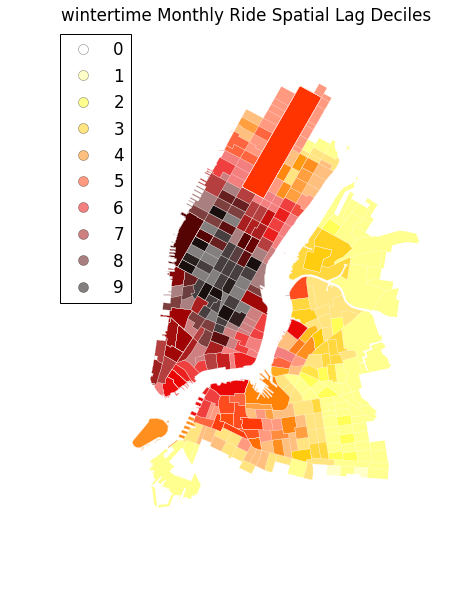

In [36]:
f, ax = plt.subplots(figsize = (7,10))
ct_shape_winterMonthlyAve_Zoom.assign(cl=winterMonthlyRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("wintertime Monthly Ride Spatial Lag Deciles")


Fig 8: The tracts with highest spatial lag are all in middle of Manhattan island below Central Park. There's less ridership on the western edge than in the summer, even adjusted for overall seasonal variation.

## Global  Spatial Autocorrelation

In [37]:
# what is happening here?
b,a = np.polyfit(winterMonthlyRide, winterMonthlyRideLag, 1)
b,a 

(0.66794043734093311, 179.12655768368859)

### Moran Scatterplot

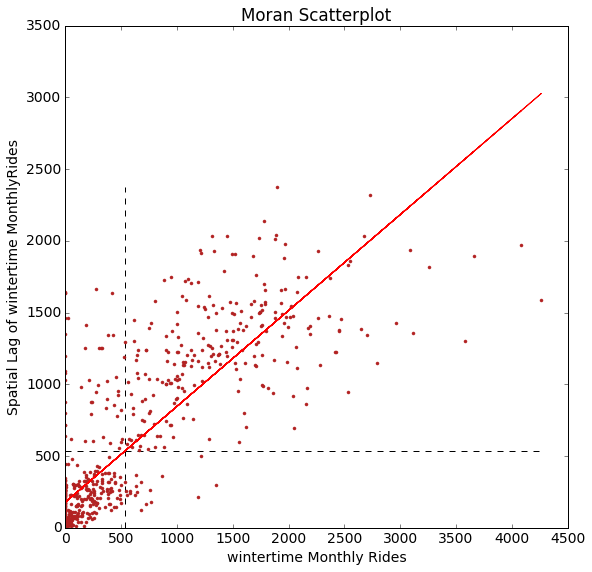

In [38]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(winterMonthlyRide, winterMonthlyRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(winterMonthlyRide.mean(), winterMonthlyRideLag.min(), winterMonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(winterMonthlyRideLag.mean(), winterMonthlyRide.min(), winterMonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(winterMonthlyRide, a + b*winterMonthlyRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of wintertime MonthlyRides')
plt.xlabel('wintertime Monthly Rides')

Fig 9: The more monthly rides there are in a census tract (in the winter), the more spatial lag those tracts have.

### Moran's I

In [39]:
I_winterMonthlyRide = ps.Moran(winterMonthlyRide, qW_CT_winter)

In [40]:
I_winterMonthlyRide.I, I_winterMonthlyRide.p_sim

(0.66811761507898915, 0.001)

Thus, the $I$ statistic is $0.6441$ for this data, and has a very small $p$ value. 

In [41]:
I_winterMonthlyRide.sim[0:10]

array([ 0.01221524, -0.01678972,  0.00803013,  0.00252592, -0.00093025,
       -0.00067428,  0.02289918,  0.00104236,  0.00106824, -0.00406376])

### Kernel Density Estimation (KDE) plot of all of the wintertime simulated points
Wikipedia: KDE "is a non-parametric way to estimate the probability density function of a random variable. Kernel density estimation is a fundamental data smoothing problem where inferences about the population are made, based on a finite data sample."
the vertical line shows the observed value

Note: I don't really understand this section. Latter part of analysis in the lab wasn't explained in class.

In [42]:
import seaborn as sns
plt.rcParams['figure.figsize']=(14,3)

(-0.7, 0.7)

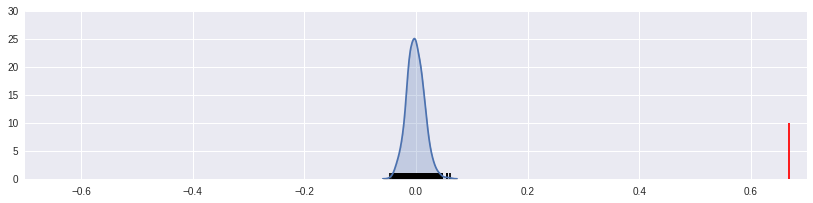

In [43]:
sns.kdeplot(I_winterMonthlyRide.sim, shade=True)
plt.vlines(I_winterMonthlyRide.sim, 0, 1)
plt.vlines(I_winterMonthlyRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

Fig 10: What's This?

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

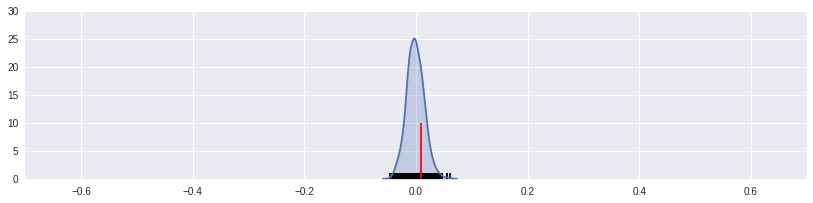

In [44]:
sns.kdeplot(I_winterMonthlyRide.sim, shade=True)
plt.vlines(I_winterMonthlyRide.sim, 0, 1)
plt.vlines(I_winterMonthlyRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

Fig 11: What's This?

## Local  Spatial Autocorrelation

In [45]:
LMo_winterMonthlyRide = ps.Moran_Local(winterMonthlyRide, qW_CT_winter, permutations=999)

In [46]:
LMo_winterMonthlyRide.Is[0:5], LMo_winterMonthlyRide.p_sim[0:5]

(array([-0.        , -0.33241898, -0.00233046,  0.00177412, -0.04749022]),
 array([ 0.001,  0.137,  0.432,  0.455,  0.441]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [47]:
sigs = winterMonthlyRide[LMo_winterMonthlyRide.p_sim <= .001]
W_sigs = winterMonthlyRideLag[LMo_winterMonthlyRide.p_sim <= .001]
insigs = winterMonthlyRide[LMo_winterMonthlyRide.p_sim > .001]
W_insigs = winterMonthlyRideLag[LMo_winterMonthlyRide.p_sim > .001]

### Plot Significant LISA

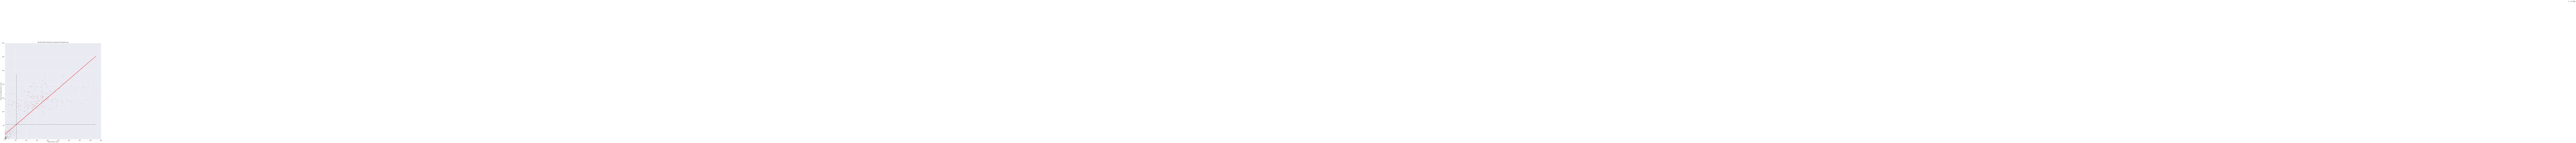

In [54]:
# why so small?
f, ax = plt.subplots(figsize=(18, 18))
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_winterMonthlyRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(winterMonthlyRide.mean(), winterMonthlyRideLag.min(), winterMonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(winterMonthlyRideLag.mean(), winterMonthlyRide.min(), winterMonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(winterMonthlyRide, a + b*winterMonthlyRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Monthly Rides in winter')
plt.xlabel('Monthly Rides in winter')
plt.title('Monthly Winter Ridership Compared with Spatial Lag')

Fig 12: Don't know why this is tiny, but it again shows a positive relationship between average number of rides per month per tract and spatial lag.

### Hot and Cold spots 

In [51]:
sig_winter = LMo_winterMonthlyRide.p_sim < 0.01
hotspots_winter = LMo_winterMonthlyRide.q==1 * sig_winter
coldspots_winter = LMo_winterMonthlyRide.q==3 * sig_winter
print "Number of Hotspots:", hotspots_winter.sum()
print "Number of Coldspots:", coldspots_winter.sum()

 Number of Hotspots: 198
Number of Coldspots: 219


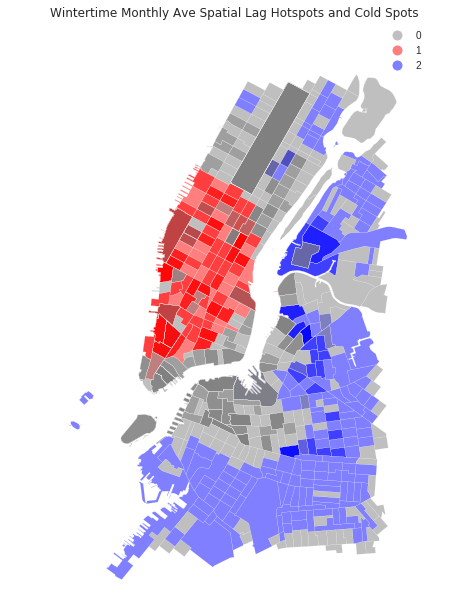

In [53]:
from matplotlib import colors

hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold_winter = hotspots_winter*1 + coldspots_winter*2

f, ax = plt.subplots(figsize=(7, 10))
ct_shape_winterMonthlyAve_Zoom.assign(cl=hotcold_winter).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Wintertime Monthly Ave Spatial Lag Hotspots and Cold Spots")

Fig 13: I think this shows places with lots of spatial lag (hotspots) and places with little spatial lag (coldspots). It's almost exactly like Fig 13 from the other notebook showing the summertime data, with the winter months perhaps showing slighty more hotspots. This means that throughout the year, spatial autocorrelation is relatively constant.